(50000, 28, 28) (50000,)


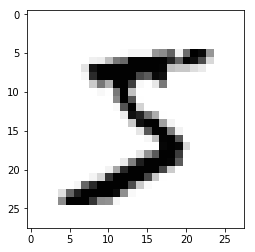

In [80]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [81]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import math

m = X_train.shape[0]
X_train_clean = X_train.reshape((-1, m))
y_train_clean = np.zeros((10,m))
y_train_clean[y_train,np.arange(m)]=1

m = X_test.shape[0]
X_test_clean = X_test.reshape((-1, m))
y_test_clean = np.zeros((10,m))
y_test_clean[y_test,np.arange(m)]=1 

print ("number of training examples = " + str(X_train_clean.shape[1]))
print ("number of test examples = " + str(X_test_clean.shape[1]))
print ("X_train shape: " + str(X_train_clean.shape))
print ("Y_train shape: " + str(y_train_clean.shape))
print ("X_test shape: " + str(X_test_clean.shape))
print ("Y_test shape: " + str(y_test_clean.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (784, 50000)
Y_train shape: (10, 50000)
X_test shape: (784, 10000)
Y_test shape: (10, 10000)


In [82]:
def create_placeholder(n_x, n_y):
    
    X = tf.placeholder(tf.float32, [n_x, None], name='X')
    Y = tf.placeholder(tf.float32, [n_y, None], name='Y')
    
    return X,Y

In [83]:
def create_parameters(n_x, n_y):
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [50, n_x], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [50,1], initializer=tf.zeros_initializer)
    W2 = tf.get_variable("W2", [n_y,50], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [n_y,1], initializer=tf.zeros_initializer)
    
    parameters = {"W1":W1,
                  "b1":b1,
                  "W2":W2,
                  "b2":b2}
    
    return parameters

In [84]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    z1 = tf.add(tf.matmul(W1,X),b1)
    a1 = tf.nn.relu(z1)
    z2 = tf.add(tf.matmul(W2,a1),b2)
    
    return z2

In [85]:
def compute_cost(z2, Y):
    
    logits = tf.transpose(z2)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [86]:
def random_mini_batches(X, Y, mini_batch_size, seed):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [89]:
def model(X_train, y_train, X_test, y_test, learning_rate=0.0001, num_epochs=500, minibatch_size = 32):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    n_x, m = X_train.shape
    n_y = y_train.shape[0]
    costs = []
    
    X, Y = create_placeholder(n_x,n_y)
    parameters = create_parameters(n_x,n_y)
    z2 = forward_propagation(X, parameters)
    cost = compute_cost(z2, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
        
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed+1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
            
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
            
            if epoch % 2 == 0:
                print('Cost after epoch %i: %f' % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
        
        #Print cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate=' + str(learning_rate))
        plt.show
        
        #Save parameters
        parameters = sess.run(parameters)
        
        #Print Accuracy
        correct_prediction = tf.equal(tf.argmax(z2), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: y_test}))
        
        return parameters

In [90]:
parameters = model(X_train_clean, y_train_clean, X_test_clean, y_test_clean)

Cost after epoch 0: 2.324525
Cost after epoch 2: 2.295717


KeyboardInterrupt: 